<a href="https://colab.research.google.com/github/youssefdarwish37/speech-emotion-recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


to do

1. confussion matrix
2. model complexity
3. testing , tuning








# **Imports**

In [ ]:
import os
import math
import glob
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchsummary import summary
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import torch.cuda
torch.cuda.init()
cuda = torch.device('cuda')

# **Globals**

In [ ]:
#initializing all arrays used
tracks = []
tracks_resized = []
tracks_split = []
tracks_label=[]
tracks_split_label = []
sad_index = []
angry_index = []
disgust_index= []
fear_index=[]
happy_index=[]
neutral_index=[]
zcr = []
energy = []
msg = []
encoder = OneHotEncoder()
max = 0
min = math.inf
sample_rate = 8000

# **Download the Dataset and Understand the Format**

In [ ]:
## downloading dataset and reading using os 
def read(dir,file):
  global max
  global min
  filepath = f"{dir}/{file}"
  track, sample_rate = librosa.load(filepath,sr=8000,offset=0.6)
  #librosa.display.waveplot(track,sample_rate)
  tracks.append(track)
  TrackName=file.split('_')
  ## splitting the name to get each track label and assigning a number for each label of the 6
  emotion=TrackName[2]
  if emotion=='SAD':
      tracks_label.append(0)
      sad_index.append(len(tracks_label)-1)
  elif emotion=='ANG':
      tracks_label.append(1)
      angry_index.append(len(tracks_label)-1)
  elif emotion=='DIS':
      tracks_label.append(2)
      disgust_index.append(len(tracks_label)-1)

  elif emotion=='FEA':
      tracks_label.append(3)
      fear_index.append(len(tracks_label)-1)

  elif emotion=='HAP':
      tracks_label.append(4)
      happy_index.append(len(tracks_label)-1)

  elif emotion=='NEU':
      tracks_label.append(5)
      neutral_index.append(len(tracks_label)-1)
  ## calculating the min for padding and dividing to chunks

  if np.shape(track)[0] < min:
    min=np.shape(track)[0]

dir = '/content/drive/MyDrive/Crema/'
os.chdir(dir)
for file in os.listdir():
    if file.endswith(".wav"):
        read(dir,file)

In [ ]:
## divide each audio into chunks each of length of the smallest track 
def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]
  

In [ ]:
## assigning the labels to all the divided chunks as their main audio 
for i in range(len(tracks)):
  if len(tracks[i]) > min:
    for item in list(divide_chunks(tracks[i],min)):
      tracks_split.append(item)
    chunks = math.ceil(len(tracks[i])/min)
    for j in range(chunks):
      tracks_split_label.append(tracks_label[i])
  else:
    tracks_split.append(tracks[i])
    tracks_split_label.append(tracks_label[i])


In [ ]:
#padding tracks to make it all of the same size (the last chunk)
for track in tracks_split:
    if len(track) < min:
      track = np.pad(track,((0, min-len(track)),), 'constant' )
    tracks_resized.append(track)
          


In [ ]:
print(np.array(tracks_split).shape)
print(np.array(tracks_split_label).shape)

(25207,)
(25207,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


# plot and playing audio

In [ ]:
def plot(index):
  plt.plot(tracks_resized[sad_index[index]])
  plt.show()
  plt.plot(tracks_resized[angry_index[index]])
  plt.show()
  plt.plot(tracks_resized[disgust_index[index]])
  plt.show()
  plt.plot(tracks_resized[fear_index[index]])
  plt.show()
  plt.plot(tracks_resized[happy_index[index]])
  plt.show()
  plt.plot(tracks_resized[neutral_index[index]])
  plt.show()

In [ ]:
def play(audio):
  return ipd.Audio(audio,rate=sample_rate)


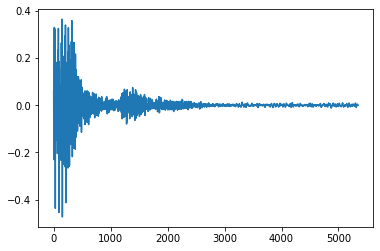

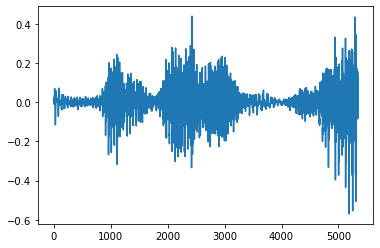

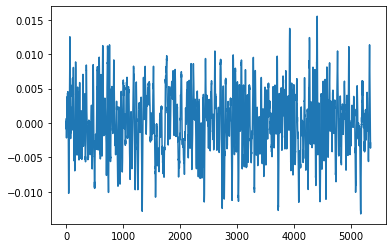

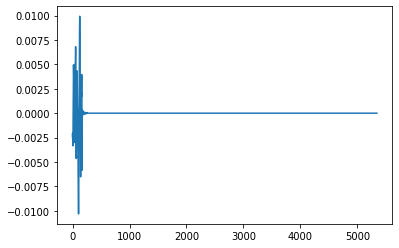

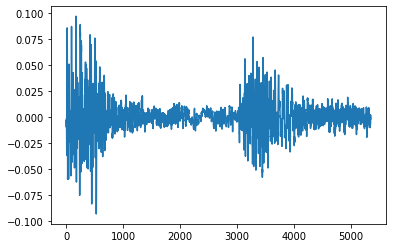

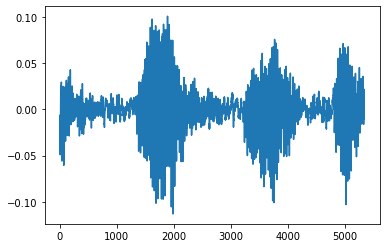

In [ ]:
plot(0)

In [ ]:
play(tracks[fear_index[0]])

#**Building the Model**

Splitting

In [ ]:
## using built in function train_test_split
def split(featureSpace,labels, testsize = 0.3):
     return train_test_split(featureSpace,labels,test_size=testsize, random_state = 42, stratify = labels)


In [ ]:
## first class for reflecting dataset  
class myDataset(Dataset):
  def __init__(self, array, label):
    self.array = array
    self.label = label

  def __getitem__(self, index):
    #takes index and return trainig example and its label

    return torch.tensor(self.array[index], dtype=torch.float),torch.tensor(self.label[index],dtype=torch.int)
  def __len__(self):
    #returns number of examples
    return len(self.array)

#1D cnn

**Create the Feature Space**

In [ ]:
## calculating zcr and energy for the 1D CNN 

def feature_space1D():
    for track in tracks_resized:
        zcr.append(librosa.feature.zero_crossing_rate(track))
        energy.append(librosa.feature.rms(track))
     
feature_space1D()



In [ ]:
## concatenting each track(chunk) with its zcr and energy 
concatenated=tracks_resized

energy=np.reshape(np.array(energy),(np.shape(energy)[0],(np.shape(energy)[2])))
zcr=np.reshape(np.array(zcr),(np.shape(zcr)[0],(np.shape(zcr)[2])))

for i in range(np.array(tracks_resized).shape[0]):
  concatenated[i]=np.append(np.array(concatenated[i]),np.array(energy[i]))
  concatenated[i]=np.append(np.array(concatenated[i]),np.array(zcr[i]))
print(np.array(concatenated).shape)

(25207, 5366)


In [ ]:
# np.save("/content/drive/MyDrive/aaaaa/Data2.npy", concatenated)
# np.save("/content/drive/MyDrive/aaaaa/DataLabels.npy", tracks_label)

In [ ]:
# concatenated=np.load("/content/drive/MyDrive/aaaaa/Data2.npy")
# tracks_label=np.load("/content/drive/MyDrive/aaaaa/DataLabels.npy")


In [ ]:
## splitting the data into 70% tarining ,30% testing and 5% of the testing for validation
fs1_train, fs1_test, label1_train, label1_test = split(concatenated,tracks_split_label)
fs1_train,valData1,label1_train,valLabel1= split(fs1_train,label1_train,0.05)


## reshaping the input data to be suitable for convloution 
fs1_train=np.reshape(fs1_train,(np.array(fs1_train).shape[0],1,np.array(fs1_train).shape[1]))
fs1_test=np.reshape(fs1_test,(np.array(fs1_test).shape[0],1,np.array(fs1_test).shape[1]))
valData1=np.reshape(valData1,(np.array(valData1).shape[0],1,np.array(valData1).shape[1]))


In [ ]:
batch_size =128
customDataset = myDataset(fs1_train,label1_train)
train1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True, num_workers = 0)

customDataset = myDataset(fs1_test,label1_test)
test1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

customDataset = myDataset(valData1,valLabel1)
validation1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

In [ ]:
## In a CNN, the input is a tensor(a tensor is an algebraic object that describes a multilinear relationship between sets of algebraic objects) 
## with a shape: (number of inputs) x (input height) x (input width) x (input channels)
## Pooling layers reduce the dimensions of data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Local pooling combines small clusters
## Fully connected layers connect every neuron in one layer to every neuron in another layer. It is the same as a traditional multilayer perceptron neural network (MLP). The flattened matrix goes through a fully connected layer to classify the images.
## dropout hiding some of the data to increase learning
##
class Model(nn.Module):
  ## main architecture class
  def __init__(self):
    ## constructor:ba3rf el layers el 3aizha hena
    super().__init__()
        ## 6 conv blocks / dropout / flatten / linear / softmax
    self.conv1 = nn.Sequential(
        nn.Conv1d(
            in_channels=1,
            out_channels=16,
            kernel_size=4,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(16).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=4)
        
    )
    self.conv2 = nn.Sequential(
        nn.Conv1d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(32).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=4)
    )
    self.conv3 = nn.Sequential(
        nn.Conv1d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(64).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=4)
    )
    self.conv4 = nn.Sequential(
        nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(128).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=4)
    )
    self.conv5 = nn.Sequential(
        nn.Conv1d(
            in_channels=128,
            out_channels=256,
            kernel_size=4,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(256).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=4)
    )
    self.conv6 = nn.Sequential(
        nn.Conv1d(
            in_channels=256,
            out_channels=512,
            kernel_size=2,
            stride=1,
            padding=2
        ),
        nn.BatchNorm1d(512).to(cuda),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2)
    )
    # self.conv7 = nn.Sequential(
    #     nn.Conv1d(
    #         in_channels=512,
    #         out_channels=1024,
    #         kernel_size=4,
    #         stride=1,
    #         padding=2
    #     ),
    #     nn.BatchNorm1d(1024).to(cuda),
    #     nn.ReLU(),
    #     nn.MaxPool1d(kernel_size=4)
    # )
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3072, 6)
    self.softmax = nn.Softmax(dim=1)
    self.dropout1 = nn.Dropout(0.3).to(cuda)
    


  def forward(self, input_data):
      x = self.conv1(input_data)
     
      x = self.conv2(x)
      
      x = self.conv3(x)
      x = self.conv4(x)
      
      x = self.conv5(x)

      x = self.dropout1(x).to(cuda)
      x = self.conv6(x)
      #x = self.conv7(x)
      x = self.dropout1(x).to(cuda)
      x = self.flatten(x)
      x = self.linear(x)
      predictions = self.softmax(x) ## probabilty for classes
      return predictions

In [ ]:
def run_model(model, train_dataloader,validation_dataloader, optimizer,train = True):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  # print(f"Using {device}")
  if train:
    model.train()
  pred_training = []
  labels_training = []
  loss = nn.CrossEntropyLoss()
  total_loss_training = 0
  for (data, label) in (train_dataloader):

    label = label.type(torch.LongTensor) # <-(casting)
    ## get the inputs; data is a list of [inputs, labels]
    data, label = data.cuda(), label.cuda()
    ## zero the parameter gradients
    optimizer.zero_grad() 
    output = model(data)
    loss_ = loss(output, label)
    total_loss_training += loss_.item()
    loss_.backward()
    optimizer.step()
    pred_training += output.tolist()
    labels_training += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()

  model.eval()
  total_loss_validation = 0
  pred_validation = []
  labels_validation = []
  for data , label in validation_dataloader:
    label = label.type(torch.LongTensor)
    data, label = data.cuda(), label.cuda()
    torch.cuda.empty_cache()
    output = model(data)
    torch.cuda.empty_cache()
    loss_ = loss(output, label)
    total_loss_validation += loss_.item()
    pred_validation += output.tolist()
    labels_validation += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()

  return labels_training, pred_training, total_loss_training/len(train_dataloader),labels_validation,pred_validation,total_loss_validation/len(validation_dataloader)



In [ ]:
del(tracks_resized)
del(energy)
del(tracks)
del(zcr)
del(tracks_split)
del(tracks_split_label)

In [ ]:
model = Model()

train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
#epoch-->repitions on all data
#lr-->learnable rate 
optimizer = torch.optim.Adam(model.parameters(),lr=0.00005,weight_decay= 0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 3)

for e in range(50):
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation  = run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  # labels_training, pred_training, loss_training= run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())

  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))
  scheduler.step(loss_validation)
  print("\nepoch =",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")




RuntimeError: ignored

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, np.array(fs1_train[0]).shape,128)

In [ ]:
from google.colab import files


fig, ax = plt.subplots()
plt.ylim(0,0.5)
plt.xlim(0,50)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D')
plt.show()


In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(1.4,1.8)
plt.xlim(0,50)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D')
plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def test_model(model, test_dataloader, train = False):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  
  # print(f"Using {device}")
  # turn off autograd for testing evaluation

  
  # set the model in evaluation mode
  model.eval()
  loss = nn.CrossEntropyLoss()

  
  # initialize a list to store our predictions
  preds = []
  total_loss_test = 0
  # loop over the test set
  for (x, y) in test_dataloader:
    y = y.type(torch.LongTensor)
    x, y = x.cuda(), y.cuda()
    # make the predictions and add them to the list
    output = model(x)
    preds.extend(output.argmax(axis=1).cpu().numpy())
    loss_ = loss(output, y)
    total_loss_test += loss_.item()

    torch.cuda.empty_cache()
  return preds, total_loss_test/len(test_dataloader)

pred,loss=test_model(model,test1_dataloader)
cm = confusion_matrix(label1_test,pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print('f1 score: ', f1_score(label1_test,pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label1_test,pred))

Class 3 (Fear) is the most confusing class


#2D **cnn**

**Create the Feature Space**

In [ ]:
chroma=[]
def feature_space2D_chroma():
    for track in tracks_resized:
        chroma.append(librosa.feature.chroma_stft(track, sample_rate))
    fig, ax = plt.subplots()
    chroma_db = librosa.power_to_db(chroma[0], ref=np.max)
    img = librosa.display.specshow(chroma_db, x_axis='time',
                                   y_axis='mel', sr=sample_rate,
                                   fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency chroma')
feature_space2D_chroma()    


In [ ]:
msg=[]
def feature_space2D_msg():
    for track in tracks_resized:
        msg.append(librosa.feature.melspectrogram(track, sample_rate))
    fig, ax = plt.subplots()
    msg_db = librosa.power_to_db(msg[0], ref=np.max)
    img = librosa.display.specshow(msg_db, x_axis='time',
                                   y_axis='mel', sr=sample_rate,
                                   fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
feature_space2D_msg()    




In [ ]:
print(np.array(msg).shape)
print(np.array(chroma).shape)




for i in range(np.array(msg).shape[0]):
  msg[i]=np.concatenate((np.array(msg[i]),np.array(chroma[i])),axis=0)

print(np.array(msg).shape)

In [ ]:
# np.save("/content/drive/MyDrive/aaaaa/Data.npy", msg)
# np.save("/content/drive/MyDrive/aaaaa/DataLabels.npy", tracks_label)

In [ ]:
# msg=np.load("/content/drive/MyDrive/aaaaa/Data.npy")
# tracks_label=np.load("/content/drive/MyDrive/aaaaa/DataLabels.npy")

In [ ]:

fs2_train, fs2_test, label2_train, label2_test = split(msg,tracks_split_label)
fs2_train,valData2,label2_train,valLabel2= split(fs2_train,label2_train,0.05)

print(np.array(fs2_train).shape)
fs2_train=np.reshape(fs2_train,(np.array(fs2_train).shape[0],1,np.array(fs2_train).shape[1],np.array(fs2_train).shape[2]))
print(np.array(fs2_train).shape)
print(np.array(fs2_test).shape)
fs2_test=np.reshape(fs2_test,(np.array(fs2_test).shape[0],1,np.array(fs2_test).shape[1],np.array(fs2_test).shape[2]))
print(np.array(fs2_test).shape)
print(np.array(valData2).shape)
valData2=np.reshape(valData2,(np.array(valData2).shape[0],1,np.array(valData2).shape[1],np.array(valData2).shape[2]))
print(np.array(valData2).shape)

In [ ]:
batch_size = 64
customDataset = myDataset(fs2_train,label2_train)
train2_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True, num_workers = 0)

customDataset = myDataset(fs2_test,label2_test)
test2_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

customDataset = myDataset(valData2,valLabel2)
validation2_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)


In [ ]:
class Model(nn.Module):
  #main architecture class
  def __init__(self):
      #constructor:ba3rf el layers el 3aizha hena
    super(Model,self).__init__()
        # 4 conv blocks / flatten / linear / softmax
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=5,
            stride=1,
            padding=2
        ),
        nn.BatchNorm2d(256).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=1)
        
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.BatchNorm2d(128).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=3)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.BatchNorm2d(64).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.BatchNorm2d(64).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )


    self.flatten = nn.Flatten()
    self.linear = nn.Linear(4800, 18)
    self.linear2 = nn.Linear(18, 6)
    self.softmax = nn.Softmax(dim=1)
    self.dropout1 = nn.Dropout(0.5).to(cuda)

  def forward(self, input_data):
      x = self.conv1(input_data)
      x = self.dropout1(x).to(cuda)
      x = self.conv2(x)
 
      x = self.conv3(x)
      x = self.dropout1(x).to(cuda) 

      x = self.conv4(x)

   
      x = self.flatten(x)
      x = self.linear(x) 
      x = self.dropout1(x).to(cuda)    
      logits = self.linear2(x)
      
      predictions = self.softmax(logits)
      return predictions

In [ ]:
def run_model(model, train_dataloader,validation_dataloader, optimizer,train = True):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  # print(f"Using {device}")
  if train:
    model.train()
  pred_training = []
  labels_training = []
  loss = nn.CrossEntropyLoss()
  total_loss_training = 0
  for (data, label) in train_dataloader:
    label = label.type(torch.LongTensor) # <-(casting)
    data, label = data.cuda(), label.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss_ = loss(output, label)
    total_loss_training += loss_.item()
    loss_.backward()
    optimizer.step()
    pred_training += output.tolist()
    labels_training += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()

  model.eval()
  total_loss_validation = 0
  pred_validation = []
  labels_validation = []
  for data , label in validation_dataloader:
    label = label.type(torch.LongTensor)
    data, label = data.cuda(), label.cuda()
    output = model(data)
    loss_ = loss(output, label)
    total_loss_validation += loss_.item()
    pred_validation += output.tolist()
    labels_validation += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()
  return labels_training, pred_training, total_loss_training/len(train_dataloader),labels_validation,pred_validation,total_loss_validation/len(validation_dataloader)


In [ ]:
model = Model()
#epoch-->repitions on all data
epoch  = 50
train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 3)

for e in range(epoch):

  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation = run_model(model, train2_dataloader,validation2_dataloader,optimizer,scheduler)
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())
  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))

  scheduler.step(loss_validation)
  print("\nepoch=",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")


In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, np.array(fs2_train[0]).shape,128)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def test_model(model, test_dataloader, train = False):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  
  # print(f"Using {device}")
  # turn off autograd for testing evaluation

  
  # set the model in evaluation mode
  model.eval()
  loss = nn.CrossEntropyLoss()

  
  # initialize a list to store our predictions
  preds = []
  total_loss_test = 0
  # loop over the test set
  for (x, y) in test_dataloader:
    y = y.type(torch.LongTensor)
    x, y = x.cuda(), y.cuda()
    # make the predictions and add them to the list
    output = model(x)
    preds.extend(output.argmax(axis=1).cpu().numpy())
    loss_ = loss(output, y)
    total_loss_test += loss_.item()

    torch.cuda.empty_cache()
  return preds, total_loss_test/len(test_dataloader)

pred,loss=test_model(model,test2_dataloader)
cm = confusion_matrix(label2_test,pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print('f1 score: ', f1_score(label2_test,pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label2_test,pred))

In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(0,0.5)
plt.xlim(0,50)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='CNN--2D')
plt.show()



In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(1.6,1.9)
plt.xlim(0,50)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='CNN--2D')
plt.show()



In [ ]:
model = model.cpu()


In [ ]:
torch.cuda.empty_cache()

# trash

In [ ]:
# print(f1_score(label1_test.argmax(axis=1), predictions.argmax(axis=1),average = 'weighted'))
# print(accuracy_score(label1_test.argmax(axis=1), predictions.argmax(axis=1)))



In [ ]:
# model=prepare_model_1D()
# fs1_train=np.reshape(fs1_train,(np.shape(fs1_train)[0],157,1))
# fs1_train = np.array(fs1_train)
# fs1_test=np.reshape(fs1_test,(np.shape(fs1_test)[0],157,1))
# fs1_test = np.array(fs1_test)
# label1_train = np.array(label1_train)
# valData1=np.reshape(valData1,(np.shape(valData1)[0],157,1))
# valData1 = np.array(valData1)
# valLabel1 = np.array(valLabel1)
# #print(fs1_train)
# #print(label1_train)
# model.fit(fs1_train,label1_train, validation_data=(valData1,valLabel1), epochs=100, verbose=2,batch_size=32)
# predictions = model.predict(fs1_test, steps=1, verbose=0)

In [ ]:
# def run_model(model, dataloader,train = True):
#   for epoch in range(2):  # loop over the dataset multiple times
#       pred = []
#       labels = []
#       loss = nn.CrossEntropyLoss()
      
#       scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor =.3, threshold = 1e-4)
#       running_loss = 0.0
#       for i, data in enumerate(dataloader, 0):
#           # get the inputs; data is a list of [inputs, labels]
#           inputs, labels = data

#           # zero the parameter gradients
#           optimizer.zero_grad()

#           # forward + backward + optimize
#           outputs = model(inputs)
#           loss_ = loss(outputs, labels)
#           loss.backward()
#           optimizer.step()

#           # print statistics
#           running_loss += loss.item()
#           if i % 2000 == 1999:    # print every 2000 mini-batches
#               print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#               running_loss = 0.0

#   print('Finished Training')
#   return labels, pred, running_loss



In [ ]:
# model=prepare_model_2D()
# fs2_train=np.reshape(fs2_train,(np.shape(fs2_train)[0],157,1))
# fs2_train = np.array(fs2_train)
# fs2_test=np.reshape(fs2_test,(np.shape(fs2_test)[0],157,1))
# fs2_test = np.array(fs2_test)
# label2_train = np.array(label2_train)
# valData2=np.reshape(valData2,(np.shape(valData2)[0],157,1))
# valData2 = np.array(valData2)
# valLabel2 = np.array(valLabel2)
# #print(fs1_train)
# #print(label1_train)
# model.fit(fs2_train,label2_train, validation_data=(valData2,valLabel2), epochs=100, verbose=2,batch_size=32)
# predictions = model.predict(fs2_test, steps=1, verbose=0)

In [ ]:
#####another 1D model
# class Model(nn.Module):
#   #main architecture class
#   def __init__(self):
#       #constructor:ba3rf el layers el 3aizha hena
#       super(Model, self).__init__()
#       #4 conv blocks 
#       self.conv1 = nn.Sequential(
#           nn.Conv1d(in_channels=1,out_channels=256,kernel_size=5,stride=1),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=5,stride=2)
#         )
#       self.conv2 = nn.Sequential(
#           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=5,stride=1),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=5,stride=2)
#         )
#       self.conv3 = nn.Sequential(
#           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=5,stride=1),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=5,stride=2)
#         )
#       self.conv4 = nn.Sequential(
#           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5,stride=1),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=5,stride=2)
#       )
#       self.flatten = nn.Flatten()
#       #dropout beyzwd el trainig bey5be hetat
#       self.dropout1 = nn.Dropout(0.2)
#       self.dropout2 = nn.Dropout(0.3)
#       #howa beyhaded el input lama yedek error
#       self.fc1 = nn.Linear(14816,2)
#       self.fc2 = nn.Linear(2, 6)

#   def forward(self, x):
#     #el model haymshy ezay
#       x = self.conv1(x)

#       x = self.conv2(x)

#       x = self.conv3(x)

#       x = self.dropout1(x)
      
#       x = self.conv4(x)

#       x = self.dropout2(x)

#       x = self.flatten(x)
#       # x = F.relu(x)

#       x = self.fc1(x)
     
#       x = self.fc2(x)
#       return F.log_softmax(x, dim = 1)